# Import Libraries

In [1]:
# import libraries

# main
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 28
import pandas as pd
import seaborn as sns
import time

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# grid-search
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# machine learning models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#import xgboost as xgb
#from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

#import skorch
#from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import StepLR

# dimensionality reduction
from sklearn.decomposition import PCA
#from yellowbrick.model_selection import FeatureImportances

# evaluation metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

sns.set_theme(style='darkgrid')

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [2]:
# Set the default text font size
plt.rc('font', size=18)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
# Set the legend font size
plt.rc('legend', fontsize=14)
# Set the font size of the figure title
plt.rc('figure', titlesize=18)

font = {'family' : 'Cambria',
        'weight' : 'normal'}
plt.rc('font', **font)

# Data pre-processing

In [3]:
df   = pd.read_csv("combined_last.csv", sep=",")   # the file uses “;” as separator
df = df[df["Mach"] == 0.15]                      # keep only Mach = 0.15 rows

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mach               150 non-null    float64
 1   YoungsModulus3     150 non-null    float64
 2   Density1           150 non-null    float64
 3   Density3           150 non-null    float64
 4   Flutter Speed      150 non-null    float64
 5   Mass               150 non-null    float64
 6   Flutter Frequency  150 non-null    float64
dtypes: float64(7)
memory usage: 8.3 KB


In [5]:
df.describe()

,Mach,YoungsModulus3,Density1,Density3,Flutter Speed,Mass,Flutter Frequency
count,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.500000e-01,7.089228e+10,929.426820,2794.274193,67.516295,0.356465,34.591000
std,2.227885e-16,5.250291e+09,46.846696,87.594540,2.409610,0.009081,1.278643
min,1.500000e-01,6.200000e+10,850.000000,2645.000000,63.200179,0.334779,32.089895
25%,1.500000e-01,6.642913e+10,889.000250,2718.548750,65.467131,0.350311,33.547514
50%,1.500000e-01,7.100000e+10,929.333500,2793.790500,67.614295,0.356267,34.475215
75%,1.500000e-01,7.542913e+10,969.666750,2869.395250,69.551093,0.362871,35.550819
max,1.500000e-01,8.000000e+10,1010.000000,2945.000000,71.877323,0.375908,37.365350


In [6]:
# prepare X and y
X = df[['YoungsModulus3','Density1','Density3']]
y = df[['Mass']]

# print
print('Input shape: ', X.shape)
print('Output shape: ', y.shape)

Input shape:  (150, 3)
Output shape:  (150, 1)


In [7]:

# [0.8e9, 1.4e9],  # Range for Young's modulus 1
# [0.35, 0.45],  # Range for Poisson's ratio 1
# [870, 990],  # Range for density 1
# [3.5e8, 6.0e8],  # Range for Young's modulus 2
# [0.35, 0.45],  # Range for Poisson's ratio 2
# [0.01, 0.05],    # Range for density 2
# [5.5e10, 8.5e10],  # Range for Young's modulus 3
# [0.30, 0.36],  # Range for Poisson's ratio 3
# [2700, 2950],    # Range for density 3
# [0.7e6, 1.3e6],  # Range for Young's modulus 4
# [0.25, 0.35],  # Range for Poisson's ratio 4
# [0.0005, 0.0015], # Range for density 4
# [0.8e9, 1.4e9]   # Range for Young's modulus 5
# [0.35, 0.45]   # Range for Poisson's ratio 5
# [0.870, 0.990]   # Range for density 5

In [8]:
from sklearn.ensemble import IsolationForest

def clean_outliers(X, y, contamination=0.1):
    # Combine X and y for outlier detection
    data = pd.concat([X, y], axis=1)

    # Fit the model
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)

    # Predict the outliers
    y_pred = clf.predict(data)

    # Filter the data
    mask = y_pred != -1
    X_clean = X[mask]
    y_clean = y[mask]

    return X_clean, y_clean

# Clean outliers from X and y
X_clean, y_clean = clean_outliers(X, y, contamination=0.1)

print(f"Original X shape: {X.shape}")
print(f"Cleaned X shape: {X_clean.shape}")
print(f"Original y shape: {y.shape}")
print(f"Cleaned y shape: {y_clean.shape}")

Original X shape: (150, 3)
Cleaned X shape: (135, 3)
Original y shape: (150, 1)
Cleaned y shape: (135, 1)


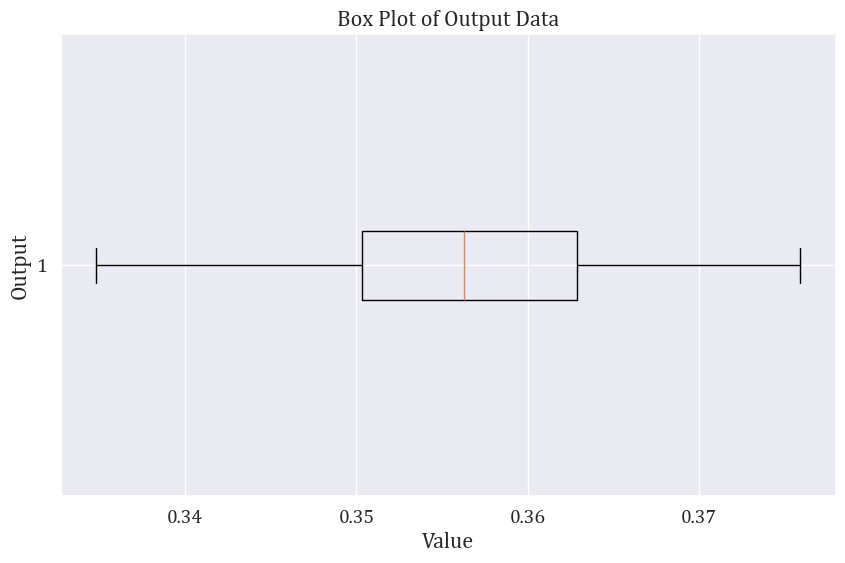

In [9]:
# Plot box plot for the y output
plt.figure(figsize=(10, 6))
plt.boxplot(y, vert=False)
plt.title('Box Plot of Output Data')
plt.xlabel('Value')
plt.ylabel('Output')
plt.show()

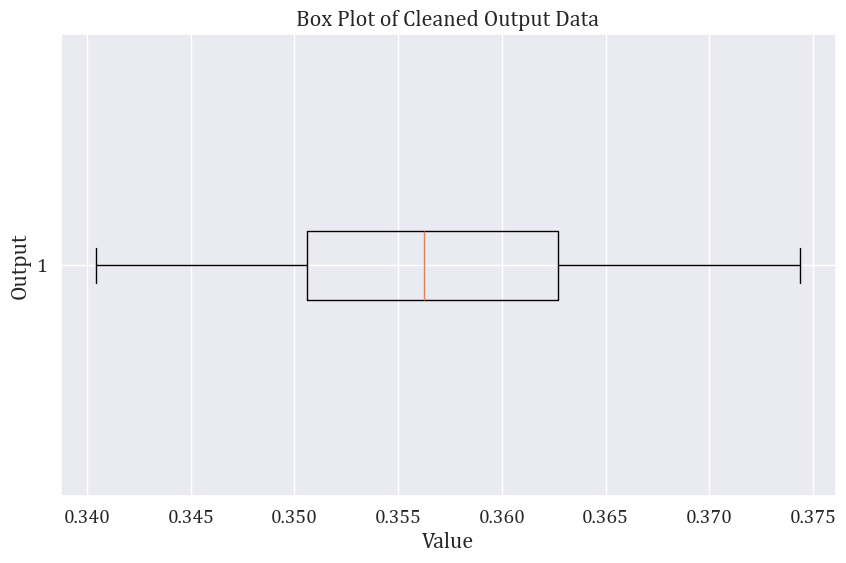

In [10]:
# Plot box plot for the y output
plt.figure(figsize=(10, 6))
plt.boxplot(y_clean, vert=False)
plt.title('Box Plot of Cleaned Output Data')
plt.xlabel('Value')
plt.ylabel('Output')
plt.show()

In [11]:
X, y = X_clean, y_clean

In [12]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVR
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score


# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the pipeline for the inputs
# input_pipeline = Pipeline([
#     ('scaler', MinMaxScaler())
# ])

# # Define the pipeline for the outputs
# output_pipeline = Pipeline([
#     ('scaler', MinMaxScaler())
# ])

# # Apply the transformations to the train and test data
# X_train_scaled = input_pipeline.fit_transform(X_train)
# X_test_scaled = input_pipeline.transform(X_test)

# y_train_scaled = output_pipeline.fit_transform(y_train)
# y_test_scaled = output_pipeline.transform(y_test)

# # Define the model
# svr = SVR()

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'estimator__C': [100, 200, 300],
#     'estimator__epsilon': [0.0001, 0.0004, 0.001],
#     'estimator__gamma': [0.01, 0.1, 0.3, 0.5, 1]
# }

# # Wrap the SVR in a MultiOutputRegressor
# multi_svr = MultiOutputRegressor(svr, n_jobs=1)

# # Define GridSearchCV
# grid_search = GridSearchCV(multi_svr, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)

# # Fit the model using GridSearchCV
# grid_search.fit(X_train_scaled, y_train_scaled)

# # Get the best estimator from the grid search
# best_model = grid_search.best_estimator_

# # Predict on train and test sets
# y_train_pred = best_model.predict(X_train_scaled)
# y_test_pred = best_model.predict(X_test_scaled)

# # Inverse transform the predictions and the true values for comparison
# y_train_pred_inv = output_pipeline.inverse_transform(y_train_pred)
# y_test_pred_inv = output_pipeline.inverse_transform(y_test_pred)
# y_train_inv = output_pipeline.inverse_transform(y_train_scaled)
# y_test_inv = output_pipeline.inverse_transform(y_test_scaled)

# # Calculate R² scores
# train_r2 = r2_score(y_train_inv, y_train_pred_inv)
# test_r2 = r2_score(y_test_inv, y_test_pred_inv)

# # Print the R² scores
# print(f"Train R² Score: {train_r2:.4f}")
# print(f"Test R² Score: {test_r2:.4f}")

# # Print the best model parameters
# print("Best model parameters:")
# print(grid_search.best_params_)


In [13]:
# # Adjust the figure size as needed
# plt.figure(figsize=(15, 10))

# # Create the heatmap with adjusted annotation font size
# heatmap = sns.heatmap(X_train.corr().round(2), vmin=-1, vmax=1, annot=True, cmap='viridis', annot_kws={"size": 12})

# # Optional: Add labels, title, or save the figure
# # plt.title('L3 AERO-STRUCTURAL BENCHMARK PROBLEM (3D) Train Dataset - Heatmap')
# # plt.savefig('images/l3_3D_heatmap.png', dpi=200, bbox_inches='tight')

# plt.show();

In [14]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score

# ------------------------------------------------------------------
# 1) split data
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y.squeeze(),           # <-- make sure y is 1-D
    test_size=0.20,
    shuffle=True,
    random_state=42
)

# ------------------------------------------------------------------
# 2) helper that builds the end-to-end estimator
#    (X-scaler → SVR)   + automatic y-scaler
# ------------------------------------------------------------------
def build_model(C, epsilon, gamma):
    inner = Pipeline(
        [
            ("x_scaler", MinMaxScaler()),
            ("svr", SVR(C=C, epsilon=epsilon, gamma=gamma)),
        ]
    )

    # scales / inverse-scales the *target* transparently
    return TransformedTargetRegressor(
        regressor=inner,
        transformer=MinMaxScaler()
    )

# ------------------------------------------------------------------
# 3) Optuna objective
# ------------------------------------------------------------------
def objective(trial):
    params = {
        "C":       trial.suggest_loguniform("C",       1e-4, 1e4),
        "epsilon": trial.suggest_loguniform("epsilon", 1e-4, 1e1),
        "gamma":   trial.suggest_loguniform("gamma",   1e-4, 1e1),
    }

    model = build_model(**params)
    model.fit(X_train, y_train)          # scaled in / scaled out

    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# ------------------------------------------------------------------
# 4) hyper-parameter search
# ------------------------------------------------------------------
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)
print("Best params →", study.best_params)

# ------------------------------------------------------------------
# 5) final fit & report
# ------------------------------------------------------------------
best_model = build_model(**study.best_params)
best_model.fit(X_train, y_train)

print(f"Train R²: {r2_score(y_train, best_model.predict(X_train)):.4f}")
print(f"Test  R²: {r2_score(y_test , best_model.predict(X_test )):.4f}")



[I 2025-06-16 07:39:51,143] A new study created in memory with name: no-name-7ecf5189-36ac-4277-8ca5-7410121de793
[I 2025-06-16 07:39:51,159] Trial 0 finished with value: 0.9160576828720248 and parameters: {'C': 60.960573761234286, 'epsilon': 0.13533424705124625, 'gamma': 0.024991354519022353}. Best is trial 0 with value: 0.9160576828720248.
[I 2025-06-16 07:39:51,172] Trial 1 finished with value: 0.9987010672971514 and parameters: {'C': 71.42826413451512, 'epsilon': 0.008095774537006037, 'gamma': 2.5689437363989454}. Best is trial 1 with value: 0.9987010672971514.
[I 2025-06-16 07:39:51,185] Trial 2 finished with value: -0.052220838518876045 and parameters: {'C': 0.1500471464838391, 'epsilon': 0.2638480693154041, 'gamma': 0.00020904618896840348}. Best is trial 1 with value: 0.9987010672971514.
[I 2025-06-16 07:39:51,199] Trial 3 finished with value: 0.9999969465266648 and parameters: {'C': 276.1277881570187, 'epsilon': 0.0005794836517480774, 'gamma': 0.0008916166353894694}. Best is tr

Best params → {'C': 1049.58095838975, 'epsilon': 0.00013394787170935567, 'gamma': 0.00011708810777997416}
Train R²: 1.0000
Test  R²: 1.0000


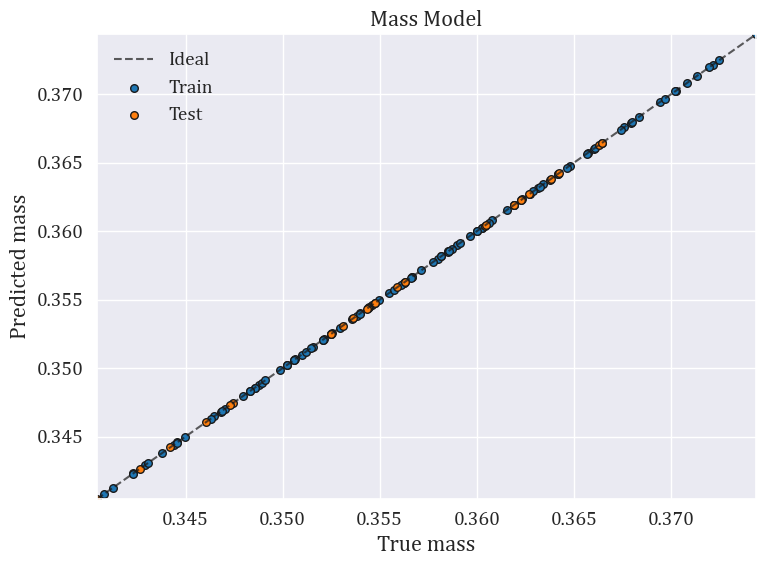

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# predictions are already in original units with the new pipeline
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

# 1-to-1 reference line
lims = [
    min(y_train.min(), y_test.min(), y_train_pred.min(), y_test_pred.min()),
    max(y_train.max(), y_test.max(), y_train_pred.max(), y_test_pred.max()),
]

plt.figure(figsize=(8, 6))
plt.plot(lims, lims, "k--", alpha=0.7, label="Ideal")

plt.scatter(y_train, y_train_pred,  s=30, c="tab:blue",   edgecolors="k", label="Train")
plt.scatter(y_test , y_test_pred ,  s=30, c="tab:orange", edgecolors="k", label="Test")

plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True mass")
plt.ylabel("Predicted mass")
plt.title( "Mass Model")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [16]:

# ------------------------------------------------------------------
# 6) example inference
# ------------------------------------------------------------------
query = pd.DataFrame(
    {
        "YoungsModulus3": [71070866141.732],
        "Density1": [904.0],
        "Density3": [2705.484],
#        "Density5": [870]
        # ...all other required columns in correct order...
    }
)
print("Predicted mass:", best_model.predict(query).item())

Predicted mass: 0.3464789199986923


In [17]:
import joblib

# `best_model` is the single TransformedTargetRegressor that already
# contains the X-scaler and the SVR inside.
joblib.dump(best_model, "mass_svr_pipeline.pkl")

# … later …
# best_model = joblib.load("mass_svr_pipeline.pkl")
# y_hat      = best_model.predict(new_X)


['mass_svr_pipeline.pkl']